In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [12]:
words = open('../data/names.txt', 'r').read().splitlines()

In [13]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['.'] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(itoch)
print(itoch)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = chtoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xval, Yval = build_dataset(words[n1:n2])   # 10%
Xtest,  Ytest  = build_dataset(words[n2:])     # 10%

torch.Size([182674, 3]) torch.Size([182674])
torch.Size([22671, 3]) torch.Size([22671])
torch.Size([22801, 3]) torch.Size([22801])


In [15]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) 
    B2 = torch.randn(vocab_size)

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2


In [45]:
def train(n_iters, lr, lossi, batch_size=32):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi    

In [31]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [32]:
def sample(n_samples=20):
    for _ in range(20):
        out = []
        context = [0] * block_size # init context with all dots ...
        while True:
            emb = C[torch.tensor([context])] # (1, block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + B1)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itoch[i] for i in out))    

In [46]:
C, W1, B1, W2, B2 = init_params()

11897


In [47]:
lossi = []
lossi = train(n_iters=50_000, lossi=lossi, lr=0.1)

step       0 of   50000: 26.0871
step   10000 of   50000: 2.7375
step   20000 of   50000: 2.3294
step   30000 of   50000: 2.3164
step   40000 of   50000: 2.4084


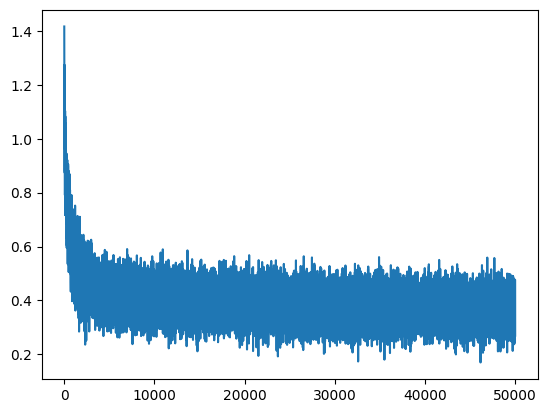

In [48]:
plt.plot(lossi)

In [50]:
split_loss('train')
split_loss('val')

train 2.381133556365967
val 2.424038887023926


In [51]:
sample()

emmeen.
ayaenni.
yani.
men.
caleiga.
amailo.
cayley.
finis.
amee.
gaeme.
fide.
noere.
aden.
ne.
nateste.
jazeellie.
vane.
lelu.
aagugneea.
kenn.


## Fixing Initialization Loss

Our initial loss is very high which then rapidly falls, this shows that the initialization isn't proper because the loss is too high. When training Neural Nets we almost always have some idea of what loss to expect at initialization.

At initialization, all characters have the same probability i.e. the probability distribution is uniform across all characters.

In [55]:
# prob for any character will be
p = torch.tensor(1 / 27.0)
loss  = -p.log()
loss

tensor(3.2958)

The initial loss expected is 3.29 which is much lower than what our first iteration has. The reason is at initialization the network is creating a random probability distribution in which some characters are very confident and some aren't which leads to the network being very confidently wrong.

In [93]:
# updating init function
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

- We have updated `B2` to be 0 because in order to bring them as close as possible to 0, we don't want to add anything to the `logits` initially.
- We have added a scale down factor of 0.01 to `W2` for the same reason that we don't want our initial values to multiply with high random numbers.

Training with our updated initialization:

In [94]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of  100000: 3.3406
step   10000 of  100000: 2.3823
step   20000 of  100000: 2.6873
step   30000 of  100000: 2.8254
step   40000 of  100000: 2.7461
step   50000 of  100000: 2.2923
step   60000 of  100000: 2.3396
step   70000 of  100000: 2.4500
step   80000 of  100000: 1.8712
step   90000 of  100000: 2.1205
train 2.1837990283966064
val 2.259556770324707


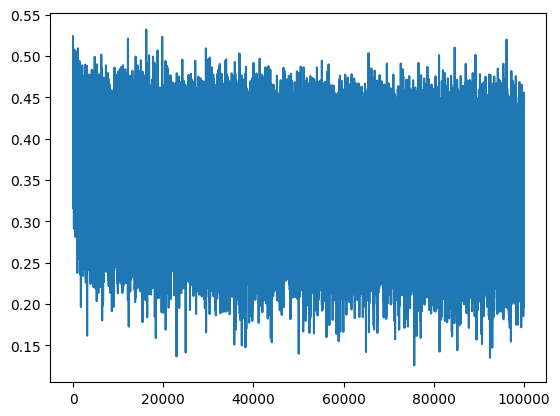

In [95]:
plt.plot(lossi)

Our initial loss has become very close to what we expect which can be seen in our plot of the loss which doesn't have the hockey shape appearance anymore.

Because of a better initialization the network has more cycles to actually optimize itself actually instead of spending the first few iteration to just squash the weights to bring them down from high random values.

## Fixing `tanh` Saturation

In [96]:
ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 
h

tensor([[ 1.0000, -0.9994, -0.9371,  ..., -0.9320, -1.0000,  0.9996],
        [ 1.0000, -0.9990,  1.0000,  ..., -0.9170, -1.0000,  0.9990],
        [ 0.8968,  0.9235, -0.9867,  ..., -0.9997,  0.8858, -0.5534],
        ...,
        [-0.8467,  0.9962,  1.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.9817,  0.9954, -0.9979,  ..., -0.9985, -1.0000,  1.0000],
        [ 0.9947, -1.0000, -0.9999,  ..., -0.9927,  1.0000, -0.9999]],
       grad_fn=<TanhBackward0>)

Notice that a lot of values in `h` are 1 or -1. The `torch.tanh` function is a squash function and squashed the values smoothly between -1 and 1. Let's take a look at the histogram of `h`.

In [97]:
h.shape

torch.Size([32, 200])

In [98]:
# stretch h into 1 large vector
h.view(-1).shape

torch.Size([6400])

In [99]:
# convert it into a list
h_list = h.view(-1).tolist()
h_list[:10]

[0.9999740123748779,
 -0.9993640184402466,
 -0.937055766582489,
 0.9008157849311829,
 -0.40095168352127075,
 -0.9949542284011841,
 0.9999987483024597,
 -0.9998396635055542,
 -0.9994168877601624,
 0.9999866485595703]

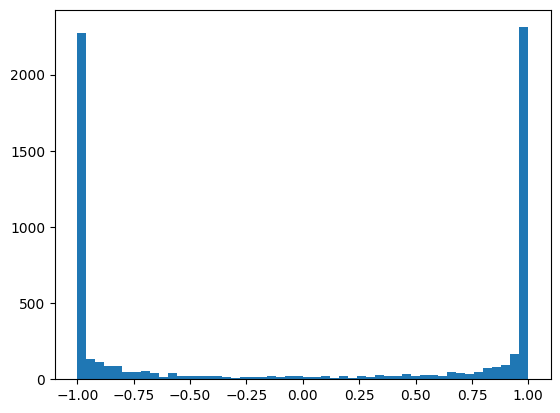

In [100]:
# draw histogram
plt.hist(h_list, 50); # semi colon to suppress output

We can confirm from the graph that most of the values are -1 and 1 which makes the `tanh` very active. 

Now let's look at the pre-activations that feed into the `tanh`.

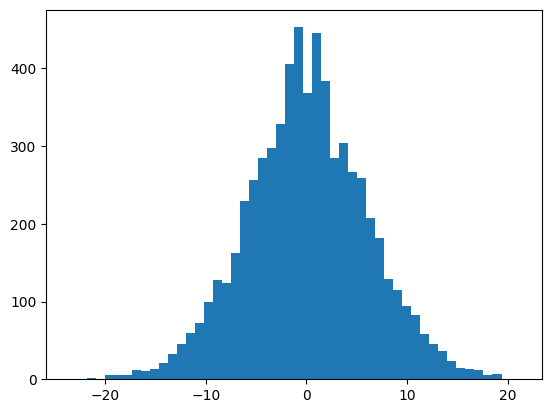

In [101]:
plt.hist(hpreact.view(-1).tolist(), 50);

Notice that the distribution of the preactivations is very broad, the numbers range from appx -25 to 25. This is the reason we have lots of -1 and 1 after we take `tanh` of these values.

### Why Is That An Issue For Backprop

When we perform backpropagation we also pass through our `tanh` layer which implements an element-wise `tanh`. The backward pass on the `tanh` layer is calculated as `self.grad += (1 - t**2) * out.grad` which means when the `tanh` of a value is 1 or -1 the gradient effectively becomes 0 i.e. we are stopping the backprop in this layer. The more closer the values are to -1 and 1, the more the gradient is squashed or destroyed.

Let's check how often `h` is in the flat regions of the `tanh` graph.

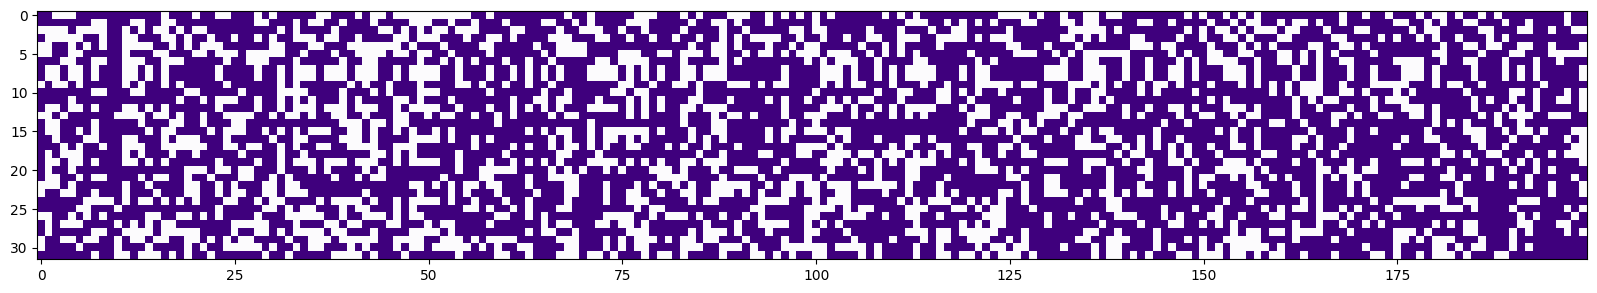

In [102]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='Purples', interpolation='nearest'); # purple if true, white if false

We can see that all the white marked neurons are in the flat tail of the `tanh` neuron and in all these cases the backward gradient will be destroyed.

**Dead Neuron**: If for any neuron in the above diagram the entire column is marked white then that neuron would be a dead neuron. That means no single example ever activates that neuron which means that neuron will never learn.

We have too many activations h that take on extreme values and the tanh neuron for that value lands in the flat region. This is not optimal and we don't want this specially during initialization because it means less training for neurons as they won't activate. It's happening because our h preactivation is too broad.

### Optimizing `hpreac`

In [103]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * 0.1
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

Our forward pass looks like this: 

```
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Yb)
```

We want `hpreact` to have values close to 0.

- So we scale down `B1` by factor of 0.01 to have a little bit of entropy at initialization.
- Scale down `W1` by factor of 0.1

In [104]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=1, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of       1: 3.3174
train 3.2715229988098145
val 3.2720887660980225


Now let's take a look at the graphs.

In [106]:
ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 

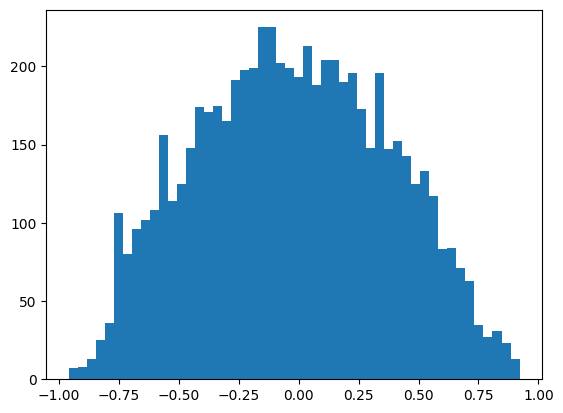

In [107]:
plt.hist(h.view(-1).tolist(), 50);

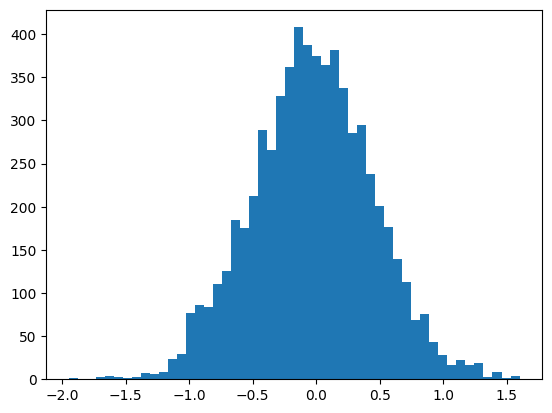

In [108]:
plt.hist(hpreact.view(-1).tolist(), 50);

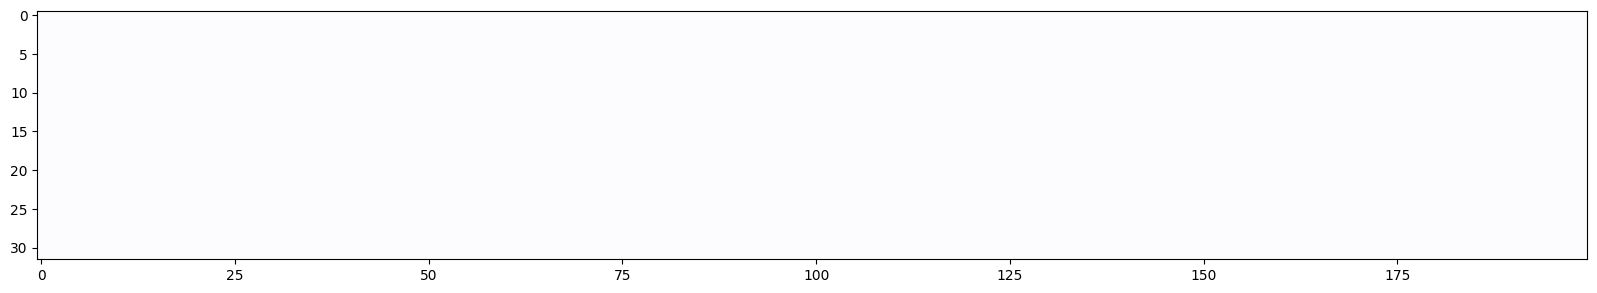

In [109]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='Purples', interpolation='nearest'); # purple if true, white if false

Now we have no values of `h.abs() > 0.99` which is a good place to be. Maybe we can have a little bit of saturation:

In [110]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden)) * 0.2
    B1 = torch.randn(n_hidden) * 0.01
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

11897
step       0 of       1: 3.2918


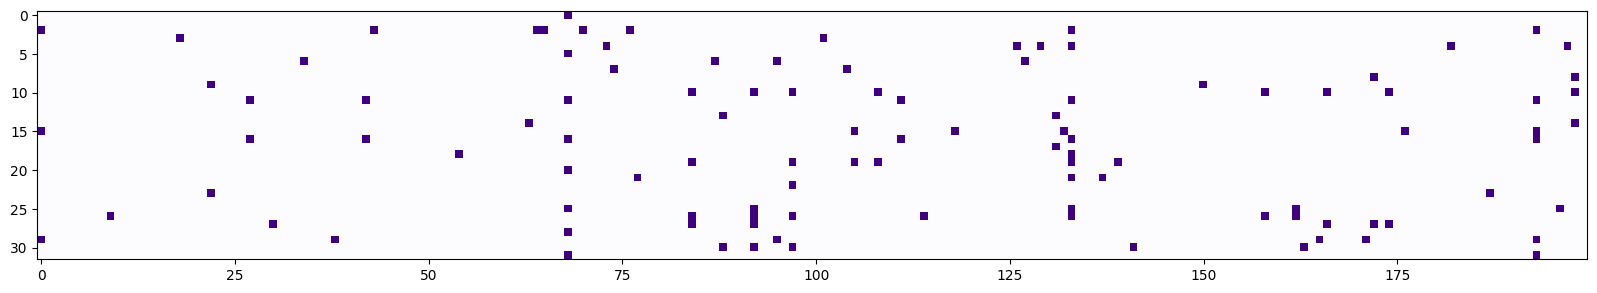

In [111]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=1, lossi=lossi, lr=0.1)

ix = torch.randint(0, Xtr.shape[0], (32, ))
Xb = Xtr[ix]
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1) 
hpreact = embcat @ W1 + B1 
h = torch.tanh(hpreact) 

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='Purples', interpolation='nearest'); # purple if true, white if false

So upon running the full optimization with the new initialization we get an improved loss:

In [112]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of  100000: 3.2945
step   10000 of  100000: 2.4178
step   20000 of  100000: 1.9584
step   30000 of  100000: 2.3261
step   40000 of  100000: 2.2434
step   50000 of  100000: 2.4012
step   60000 of  100000: 2.2592
step   70000 of  100000: 1.8956
step   80000 of  100000: 1.9153
step   90000 of  100000: 1.8692
train 2.1377060413360596
val 2.207058906555176
